In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.2.2 anndata==0.6.4 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.0 


This notebook is a continuation of the prior two notebooks exploring the pancreas data, this time with the aid of Seurat's CCA. This is isolated in its own notebook as Seurat makes use of a gigantic number of DDLs, making pre-3.5 versions of R unable to handle both that and scran simultaneously by default. Ensure that Seurat is set up to begin with.

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R

if (!('Seurat' %in% rownames(installed.packages())))
{
    install.packages("Seurat")
}

Reconstruct the data and R-bound data frames to match what was created for mnnCorrect.

In [4]:
adata = sc.read('objects-pancreas/pancreas.h5ad')
adata = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=2.5, min_disp=0.7)
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

df1 = pd.DataFrame(data=adata[adata.obs['sample']=='Baron'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Baron'].var_names,
                  columns=adata[adata.obs['sample']=='Baron'].obs_names)

df2 = pd.DataFrame(data=adata[adata.obs['sample']=='Muraro'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Muraro'].var_names,
                  columns=adata[adata.obs['sample']=='Muraro'].obs_names)

df3 = pd.DataFrame(data=adata[adata.obs['sample']=='Segerstolpe'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Segerstolpe'].var_names,
                  columns=adata[adata.obs['sample']=='Segerstolpe'].obs_names)

df4 = pd.DataFrame(data=adata[adata.obs['sample']=='Wang'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Wang'].var_names,
                  columns=adata[adata.obs['sample']=='Wang'].obs_names)

Fire up CCA. Need to do a bit of faff within R to make things appropriately Seurat'y beforehand. This is unfortunately quite output happy, prepare for much text below. At the bottom of the text you get to see the run time, which is a bit over 20 minutes.

In [5]:
%%R -i df1 -i df2 -i df3 -i df4 -o cca

suppressMessages(library(Seurat))

df1 = data.matrix(df1)
df2 = data.matrix(df2)
df3 = data.matrix(df3)
df4 = data.matrix(df4)

sdf1 = CreateSeuratObject(df1)
sdf1@meta.data$batch = '1'
sdf1 = ScaleData(sdf1)
sdf1@var.genes = rownames(df1)

sdf2 = CreateSeuratObject(df2)
sdf2@meta.data$batch = '2'
sdf2 = ScaleData(sdf2)
sdf2@var.genes = rownames(df2)

sdf3 = CreateSeuratObject(df3)
sdf3@meta.data$batch = '3'
sdf3 = ScaleData(sdf3)
sdf3@var.genes = rownames(df3)

sdf4 = CreateSeuratObject(df4)
sdf4@meta.data$batch = '4'
sdf4 = ScaleData(sdf4)
sdf4@var.genes = rownames(df4)

t1 = Sys.time()
srat = RunMultiCCA(list(sdf1, sdf2, sdf3, sdf4), genes.use=rownames(df1), num.ccs=20)
srat = AlignSubspace(srat, reduction.type='cca', grouping.var='batch', dims.align=1:20)
t2 = Sys.time()
print(t2-t1)

cca = data.frame(srat@dr$cca.aligned@cell.embeddings)

/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Scaling data matrix

  warnings.warn(x, RRuntimeWarning)
  |                                                                            it__.py:145: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |                                                                      |   0%it__.py:145: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |=======================                                               |  33%it__.py:145: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |===============================================                       |  67%it__.py:145: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |======================================================================| 100%it__.py:145: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarn

NormalizeData has not been run, therefore ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
NormalizeData has not been run, therefore ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
NormalizeData has not been run, therefore ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
NormalizeData has not been run, therefore ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
ScaleData is running on non-normalized values. Recommended workflow is to run NormalizeData first.
[1] "Computing CC 1"
[1] "Computing CC 2

Scanpy is hardwired to use `.obsm['X_pca']` for all its neighbour/UMAP needs, so we need to sneak the CCA coordinates in there. Once we do that, the UMAP reveals the batches to be better mixed than via BBKNN and the cell types to be largely merged (albeit with a few of them misplaced, either as a fault of the method or misannotation). Keep in mind this took over 20 minutes to run and BBKNN took three seconds.

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:04.61) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:08.87) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.44) --> found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


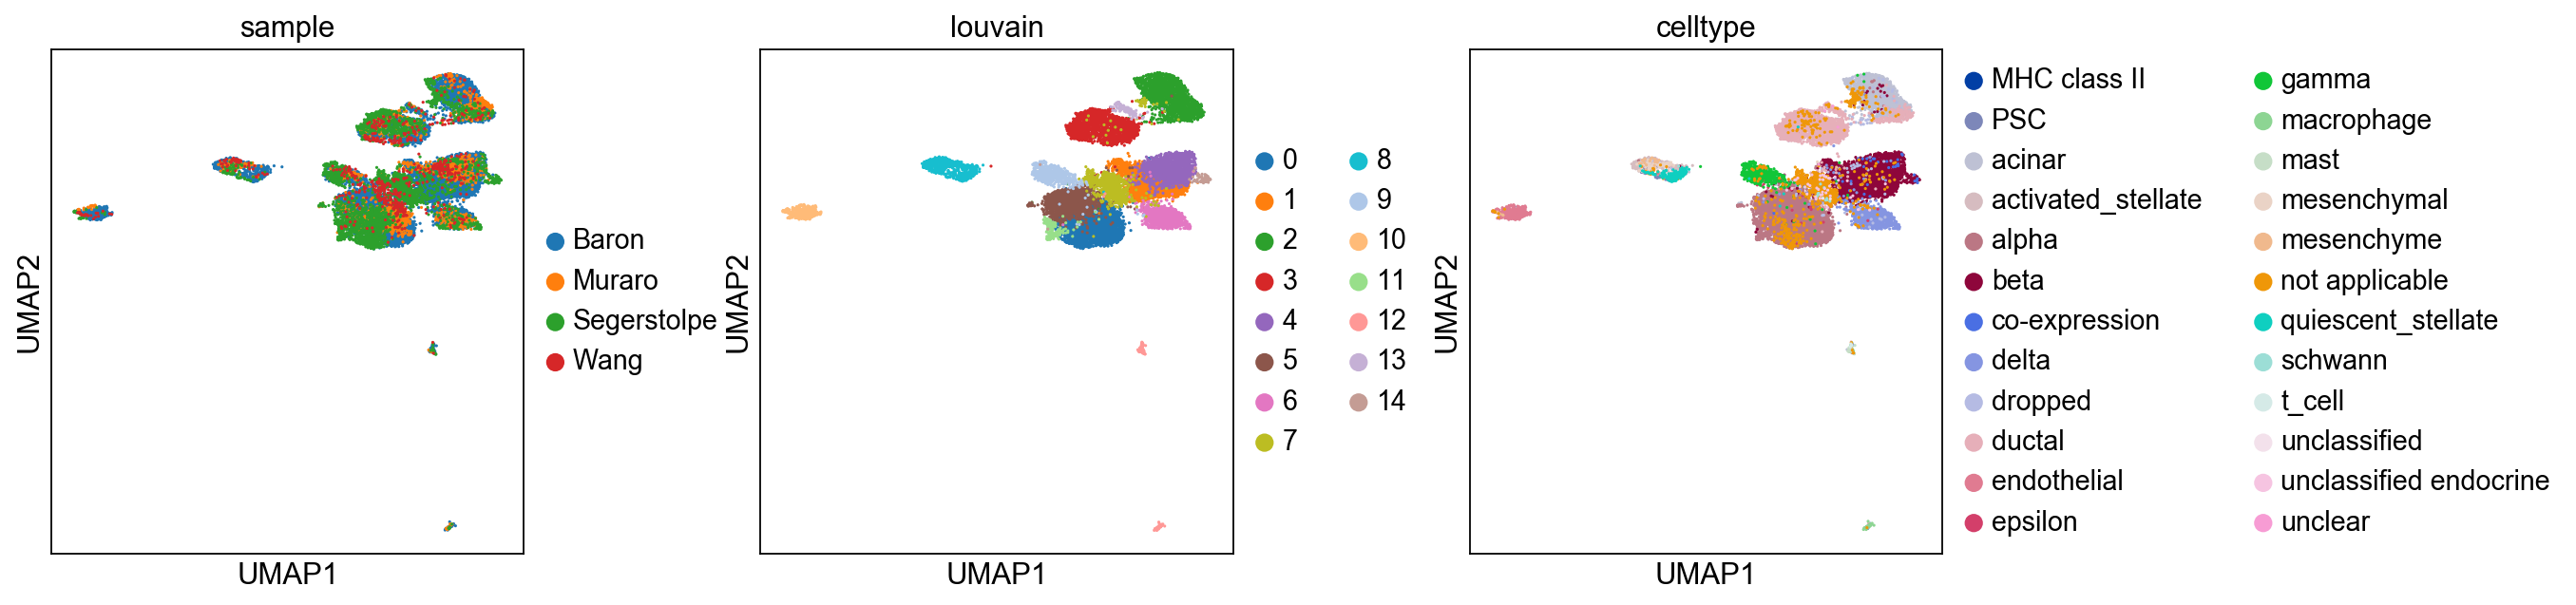

In [6]:
adata_cca = adata.copy()
adata_cca.obsm['X_pca'] = cca.values
sc.pp.neighbors(adata_cca,n_pcs=20, n_neighbors=20)
sc.tl.umap(adata_cca)
sc.tl.louvain(adata_cca)
sc.pl.umap(adata_cca, color=['sample','louvain','celltype'])

As has become tradition, save the object.

In [7]:
adata_cca.write('objects-pancreas/pancreas_cca.h5ad')